In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import env
import wrangle
import os

# turn off warning boxes for demo
import warnings
warnings.filterwarnings("ignore")


# change display settings to show all columns
pd.set_option("display.max_columns", None)

# Project Goals and Ideas
Matthew Luna, April 8, 2022

# Executive Summary
## What is driving the errors in the Zillow Zestimates?

- For this project the target is logerror
    - I created a variable 'abs_logerror' to use as the target instead
    
## Project Description
- Build a model that helps reduce the logerror for Zillow Zestimates for single family properties in 2017
- All models are compared and evaluated on its performance over the baseline

## Acquisition and Preparation

In [2]:
df = wrangle.get_zillow_data()
df.shape

Using cached csv


(77580, 69)

## Prepare process:
- After acquiring data from the mySQL server through wrangle.py
    - Become familiar with the data by:
        - using functions like .shape, .dtypes, .isna(), and .value_counts()
- Create functions in my .py file that do the following:
    - Remove columns based on % of missing values
    - Remove nulls and outliers
    - Change data types where necessary
    - Feature engineer columns like age, county, dollars_per_sqft, taxrate
    - Make dummy variables for county columns and clusters created
    - Visualize data and observe distributions
    - Clean data, split data, and scale the data

In [3]:
# Clean data and prep for splitting

df = wrangle.clean_zillow(df)

In [4]:
# Split original df into train, validate, test

train, validate, test = wrangle.split_data(df)

In [5]:
# Run handle_nulls function on splits to prepare data for exploration

train, validate, test = wrangle.handle_nulls(train, validate, test)
train.shape, validate.shape, test.shape

((34204, 26), (14659, 26), (12216, 26))

# Data Context

- The original dataset was made up of 77,580 rows and 69 columns

- After the preparation process:
    - Cleaned data is made up of 61,079 rows and 25 columns
    - Null values and outliers have been removed
    - Data types values are appropriate columns
    - Data is ready for exploration
     
    
- 78% of the original dataset remains to be explored

# Exploration

In [8]:
def show_pairplot(df):
    col_list = ['bathroomcnt','bedroomcnt', 'calculatedfinishedsquarefeet', 'dollars_per_sqft','latitude','longitude',
            'taxvaluedollarcnt','taxamount', 'age','taxrate','abs_logerror', 'logerror']

    return sns.pairplot(data = df[col_list], corner=True)

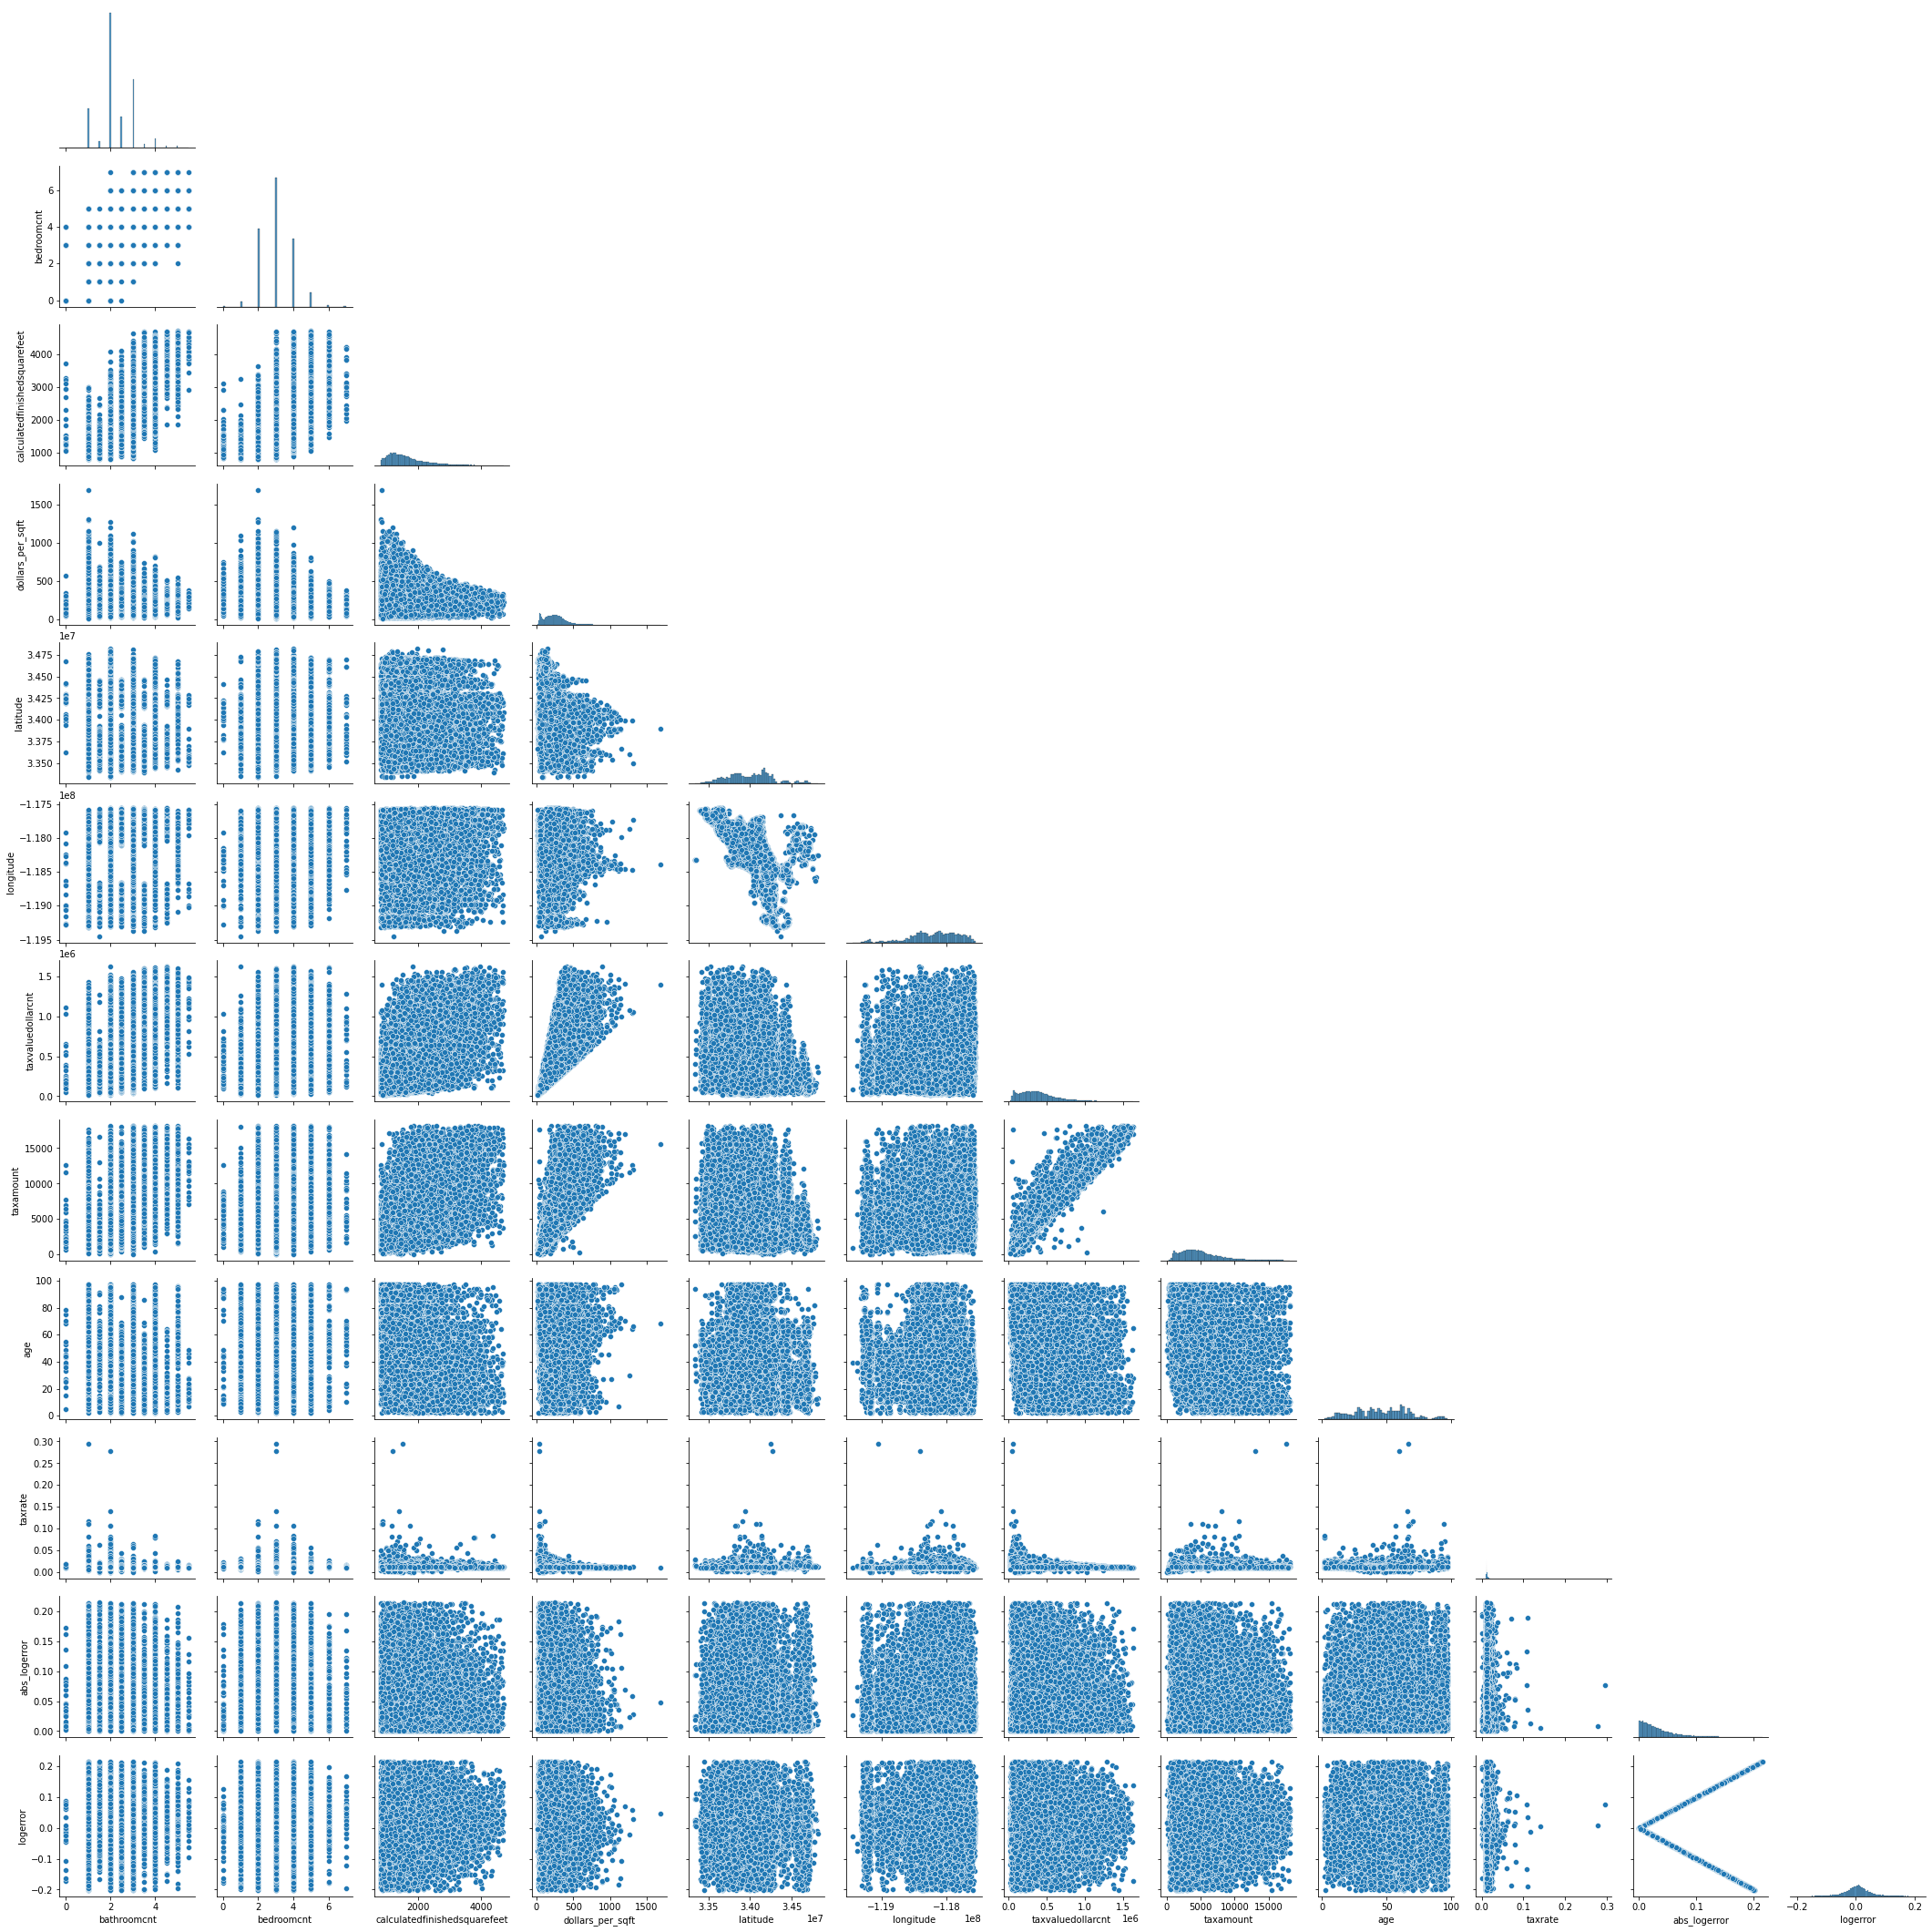

In [9]:
show_pairplot(train)

## Takeaway
     - calculatedfinishedsquarefeet has more volume for homes under about 3000 sqft
     - latitude and longitude look like there could 
     - homes in the area range all the way to 100 years

In [30]:
# Set up variables for exploration
target = 'logerror'

target2 = 'abs_logerror'

variables = ['calculatedfinishedsquarefeet',
            'dollars_per_sqft',
            'latitude',
            'longitude',
            'structuretaxvaluedollarcnt',
            'taxvaluedollarcnt',
            'landtaxvaluedollarcnt',
            'taxamount',
            'age',
            'taxrate']

In [38]:
def target_regplot(df, target, var_list, figsize = (8,5), hue = None):
    '''
    Takes in dataframe, target and varialbe list, and plots against target. 
    '''
    for var in var_list:
        plt.figure(figsize = (figsize))
        sns.regplot(data = df, x = var, y = target, 
                line_kws={'color': 'purple'})
        plt.tight_layout()

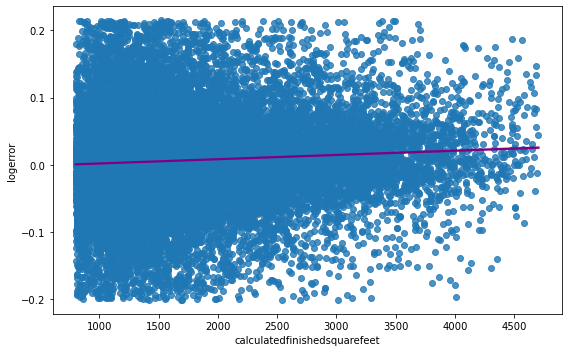

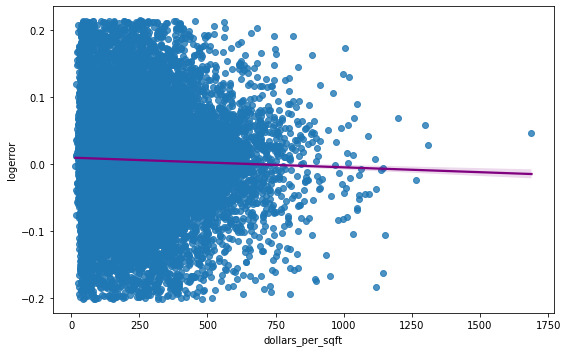

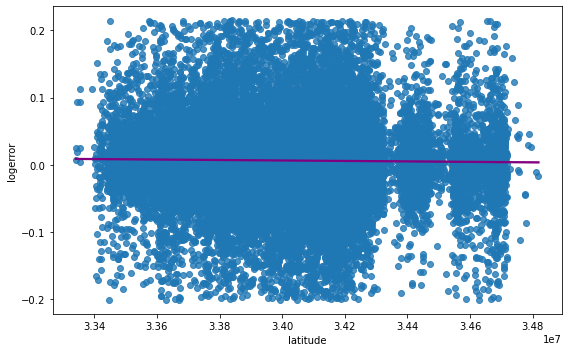

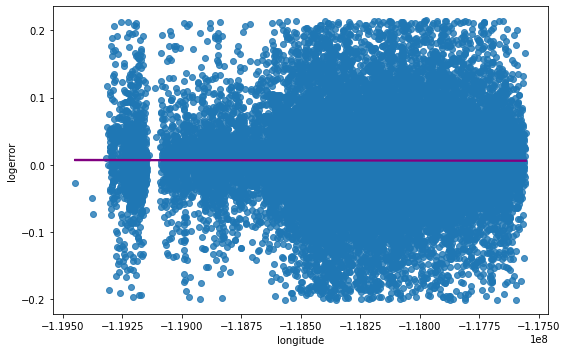

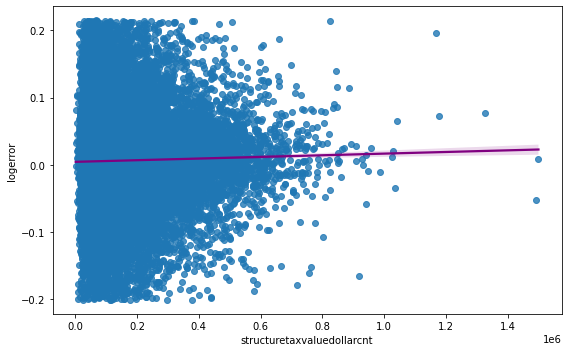

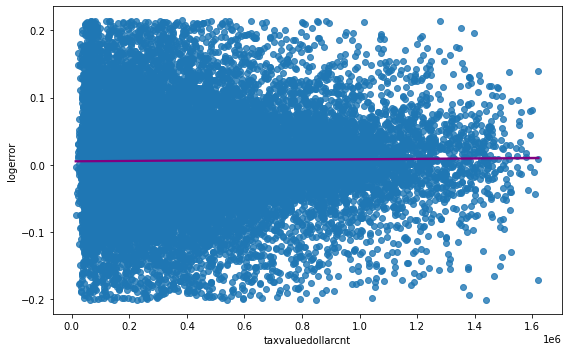

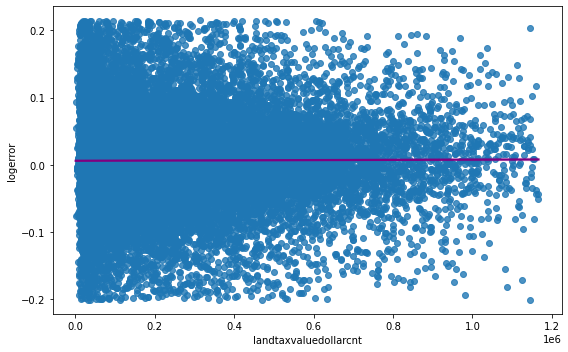

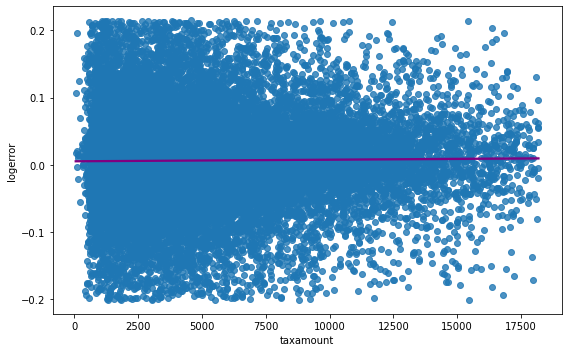

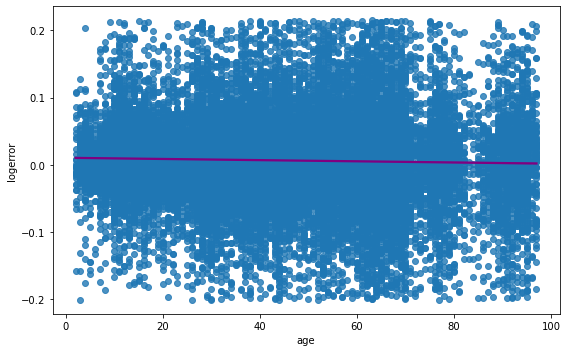

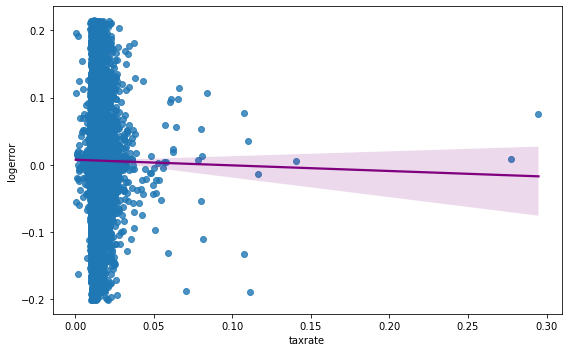

In [39]:
target_regplot(train, target, variables)

# Takeaway
- Latitude and Longitude have changes in logerror
- As square footage increase logerror reduces
- Other information is difficult to come to from this

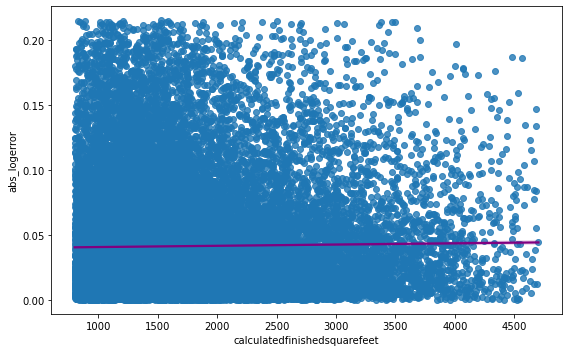

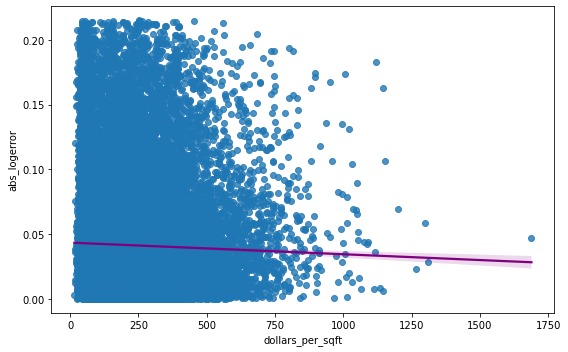

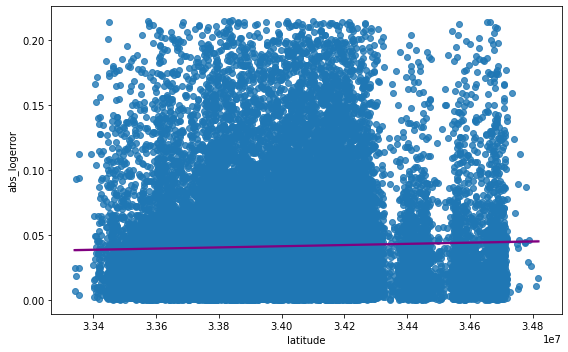

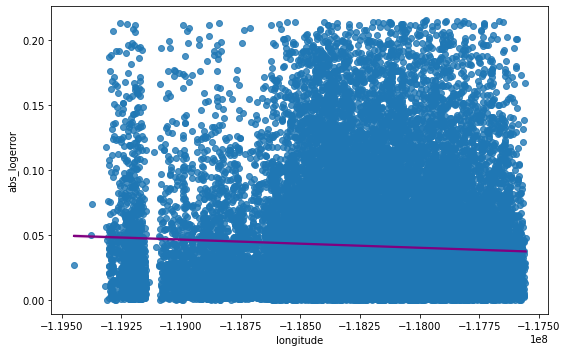

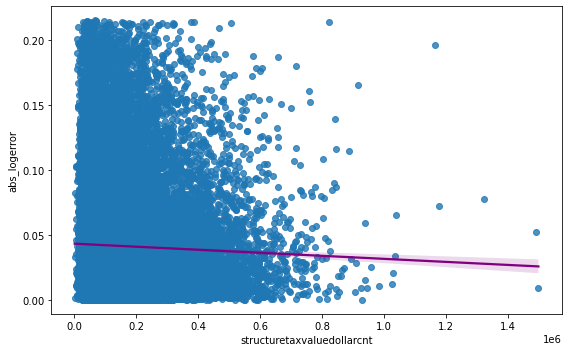

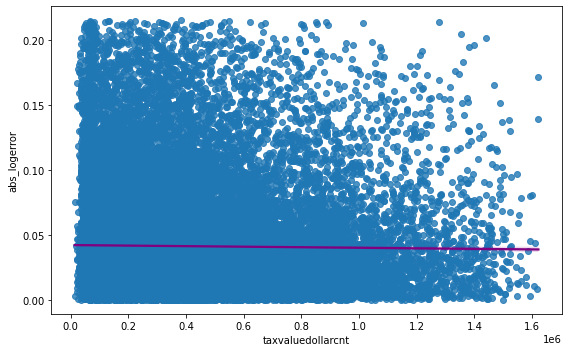

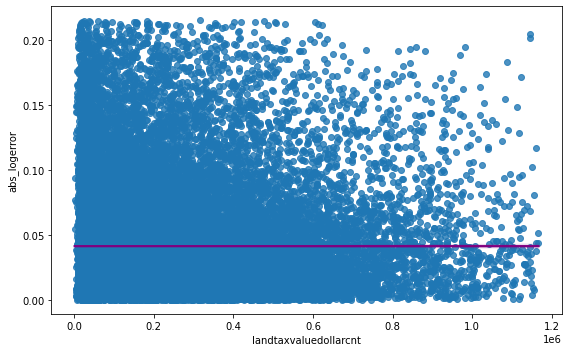

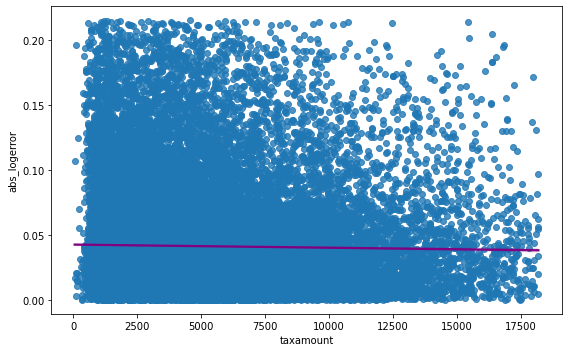

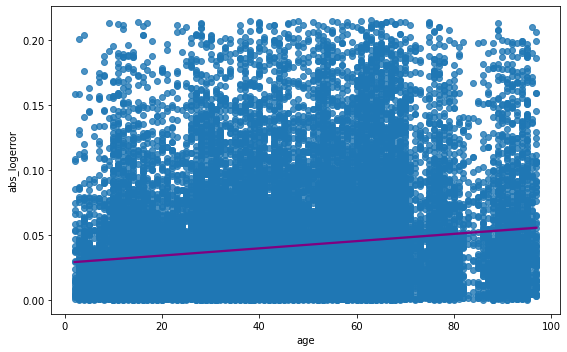

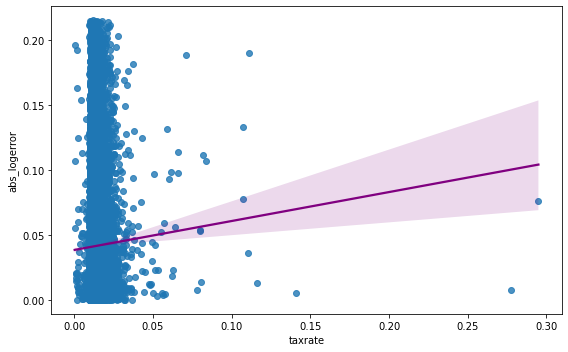

In [40]:
target_regplot(train, target2, variables)

In [67]:
def county_plots(df):
    cols = [ 'age', 'latitude', 'longitude', 'dollars_per_sqft', 'calculatedfinishedsquarefeet', 'county']

    sns.pairplot(data = train[cols], hue = 'county', corner = True)

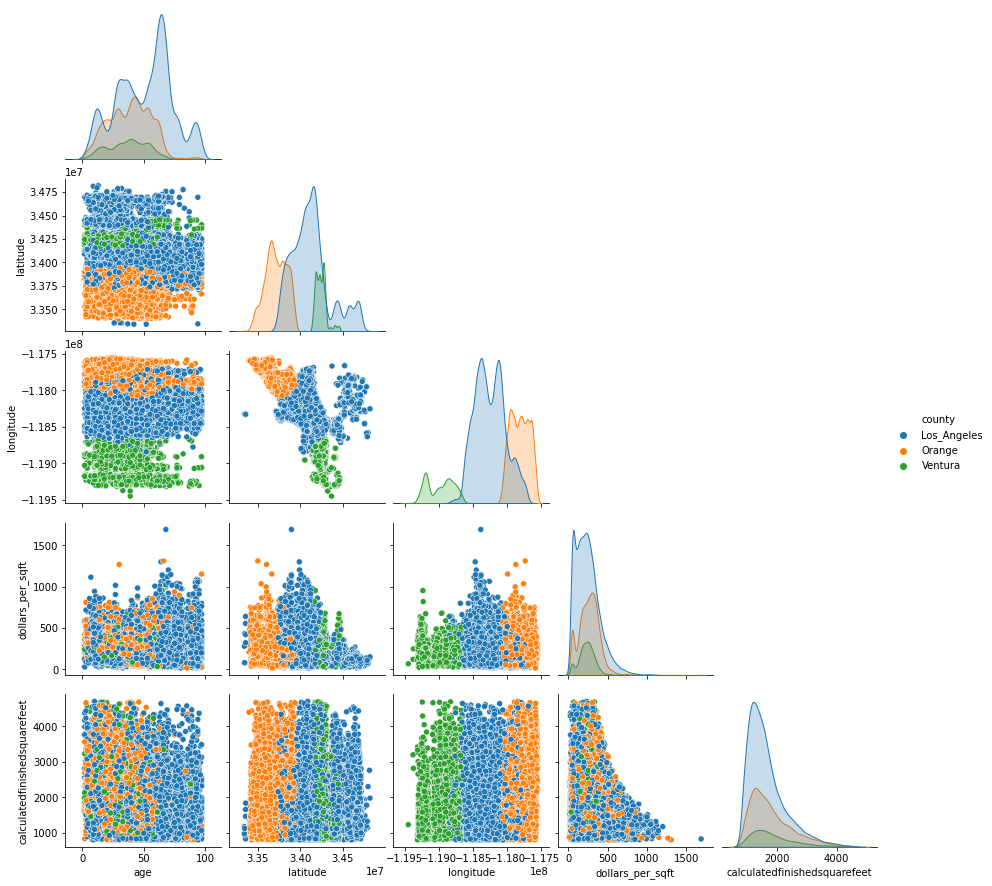

In [68]:
county_plots(train)

# Questions

- dollars_per_sqft affect logerror?
- county and logerror?
- age and logerror?
- does latitude/longitude affect logerror?

# Question 1 
    - How does county affect logerror?

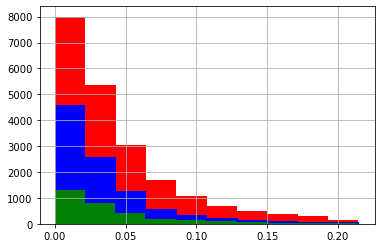

In [53]:
ax = train[train.county == 'Los_Angeles'].abs_logerror.hist(color = 'red')
train[train.county == 'Orange'].abs_logerror.hist(ax = ax, color = 'blue')
train[train.county == 'Ventura'].abs_logerror.hist(ax = ax, color = 'green')
plt.show()

#### Takeaways
- Most houses in order by county are LA, Orange, Ventura
- 50% values are very similar, lower 25%/upper 75% is where LA stands apart

### Hypothesis/Stats
- Null: Median logerror of LA county == median logerror
- Alternative: Median logerror of LA != median logerror

In [64]:
alpha = .05

t, p = stats.ttest_1samp(train[train.county == 'Orange'].abs_logerror, train['abs_logerror'].median() )
t, p 

(21.62752476725189, 2.053045132206529e-101)

- P is less than our alpha, we can reject the null hypothesis and see that logerror will vary from county to county
- WIth a positive t value we can assume that median logerror may be higher with this group

# Question 2
    - Does age affect logerror?

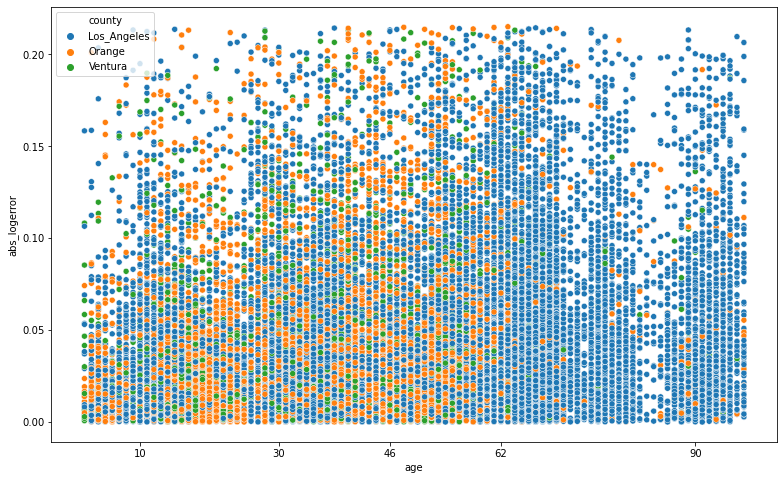

In [75]:
plt.figure(figsize = (13,8))
sns.scatterplot(train.age, train.abs_logerror, hue =train.county)
plt.xticks(ticks =(10, 30, 46, 62, 90))
plt.show()

#### Takeaway
- not too much to takeaway from logerror and mean prediction
- is interesting to see where the counties fall as far as age range

### Hypothesis/Stats
Null: There is no linear correlation between age and logerror

Alternative: There is a linear correlation between age and logerror

In [62]:
alpha = 0.05

#test = independent T-Test

r, p = stats.pearsonr(train['age'], train['abs_logerror'])
print(f't = {r}, p = {p}')

t = 0.14417405037224124, p = 2.96699112123892e-158


- p is less than our alpha, we can reject the null hypothesis
- There is evidence that a linear correlation between age and logerror is statistically significant

# Question 3
    - How does square foot of house affect logerror

<Figure size 936x576 with 0 Axes>

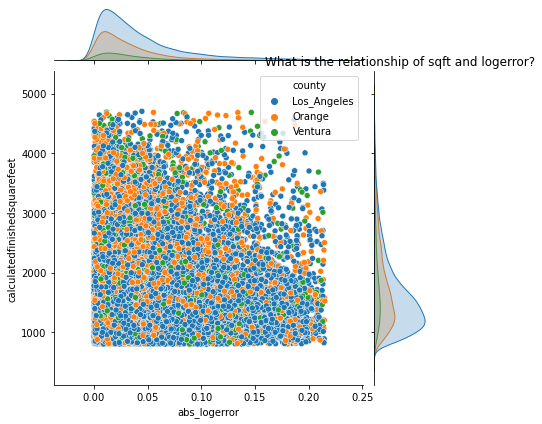

In [81]:
# visualize logerror and lotsize while controlling for newer age
plt.figure(figsize = (13,8))
sns.jointplot(x='abs_logerror', y='calculatedfinishedsquarefeet', 
                data=train, hue = 'county')
plt.title("What is the relationship of sqft and logerror?")
plt.show()

### Hypothesis/Stats
H0: There is no linear correlation between home sqft and absolute logerror

Ha:There is a linear correlation between homesqft and absolute logerror

In [77]:
alpha = 0.05

#test = Pearson r

r, p = stats.pearsonr(train['calculatedfinishedsquarefeet'], train['logerror'])
print(f't = {r}, p = {p}')

t = 0.07536355463662836, p = 2.8390495242002787e-44


- p is less than alpha, we can reject the null hypothesis
- we can assume there is a linear correlation with sqft and logerror

# Statistical analysis using Pearson's Correlation Coefficient

- Supports a linear relationship between square_ft, bathrooms, bedrooms, lot size and the property tax value

# Exploration Summary

- There are linear relationships between bedroom, bathroom, lot_size, square_ft, and tax_value assessment
- Square_ft has the strongest correlation out of the features
- The listed features will be used to fit the model and evaluate performance

# Clustering